# Домашнее задание 1. Прогнозирование с помощью простых методов и ETS

# Построение простых прогнозов (5 баллов)

## О задании

В этом домашнем задании мы немного поупражняемся с обработкой временных данных и базовыми моделями.

В приложенном файле находится всего один временной ряд. Он представляет из себя срезы некоторых значений, связанных с движениями ликвидности одного крупного российского банка. Требуется построить модель, способную прогнозировать суммарное значение этого ряда за день.

Ликвидностью обычно называют высоколиквидные активы, т.е. активы, которые легко купить и продать, чтобы быстро конвертировать в деньги. Собственно, сами по себе деньги это тоже ликвидность. Если ликвидности избыток, её можно вложить, а если недостаток -- занять.

Мы хотим прогнозировать сумму (сальдо) поступлений и списаний за день. На основании прогноза позиционер (управляет ликвидностью) принимает решение о выделении средств на размещение на рынке для получения дополнительной прибыли. В случае, если на конец дня образуется профицит ликвидности, его можно разместить в ЦБ (дать в долг) по overnight ставке. В случае, если на конец дня образуется дефицит ликвидности (опасность не вернуть долги), его можно покрыть за счет займа по overnight ставке.

## Загрузка данных

Загрузите временной ряд из файла `data_hw_1`. Преобразуйте даты во временных данных. Проверьте формат всех дат в наборе, нет ли там ошибок. Вам необходимо определить частоту данных, так как от этого будут зависеть параметры модели. Агрегируйте данные для выбраной частоты. Содержит ли новый ряд пропуски и дубликаты? Заполните пропуски, если это необходимо.

In [35]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [36]:
# ваш код
data = pd.read_csv('data_hw_1.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3909 entries, 0 to 3908
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3909 non-null   object 
 1   Target  3909 non-null   float64
dtypes: float64(1), object(1)
memory usage: 61.2+ KB


In [37]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3909 entries, 0 to 3908
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3909 non-null   datetime64[ns]
 1   Target  3909 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 61.2 KB


In [38]:
data.set_index('Date', inplace=True)

Определить частоту данных через infer_freq у меня получилось, только когда я смотрела на частоту внутри маленьких блоков данных, вышло два часа. Потом я попробовала сделать так, как ниже, тоже получилось 2 часа.

In [39]:
time_deltas = data.index.to_series().diff().dropna()
time_deltas.mode()

,Date
0,0 days 02:00:00


Проблема в том, что если так сделать, мы получим в данных много отсутствующих значений, больше, чем осмысленных денных.

In [40]:
aggregated_data = data.resample('2H').mean()
aggregated_data

,Target
Date,
2017-01-09 08:00:00,0.000000
2017-01-09 10:00:00,-0.421841
2017-01-09 12:00:00,0.105555
2017-01-09 14:00:00,0.042276
2017-01-09 16:00:00,0.071416
...,...
2020-09-16 16:00:00,NaN
2020-09-16 18:00:00,NaN
2020-09-16 20:00:00,NaN


In [41]:
aggregated_data['Target'].isna().sum()

12252

In [42]:
aggregated_data['Target'].notna().sum()

3909


и по данным видно, что с какого-то момента их стали фиксировать раз в сутки_ предсказывать нам тоже нужно сумму за день. и я решила, что имеет смысл как частоту взять как раз день.

In [43]:
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=data.index, y=data['Target'], mode='lines', name='Target'))
fig.update_layout(
    title="Target values trough time",
    xaxis_title="Date",
    yaxis_title="Target",
    showlegend=True
)

fig.show()


Тут еще видно, что много нулей проставлено в данных, кстати.

In [44]:
aggregated_data = data.resample('D').sum()
aggregated_data

,Target
Date,
2017-01-09,-0.579194
2017-01-10,-1.082260
2017-01-11,-1.515704
2017-01-12,-1.618853
2017-01-13,-1.450091
...,...
2020-09-13,0.000000
2020-09-14,3.307929
2020-09-15,2.644602


## Визуальный анализ

Изобразите временной ряд, его автокорреляции и другие графики, которые сочтёте нужным.

Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность? Как эти особенности могут помочь прогнозировать?  Ответьте на **каждый** вопрос.


In [45]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller

In [47]:
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=aggregated_data.index, y=aggregated_data['Target'], mode='lines', name='Target'))
fig.update_layout(
    title="Target values trough time",
    xaxis_title="Date",
    yaxis_title="Target",
    showlegend=True
)

fig.show()

(уже видно, что ряд не стационарный)

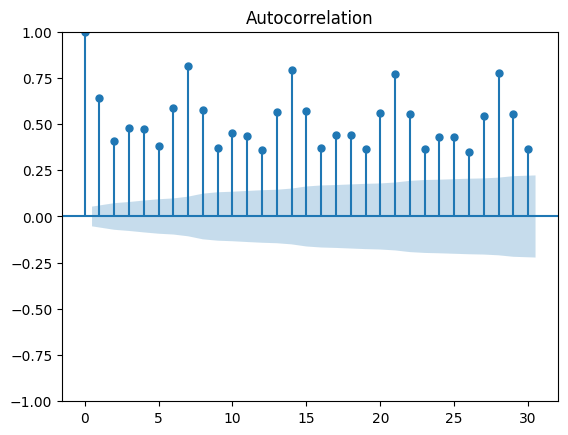

In [48]:
# ваш код
plot_acf(aggregated_data['Target'], lags=30)
plt.show()

Автокорреляция сильная, получается. И можно говорить о цикличности временного ряда (в смысле о том, что таковая есть), потому что в графике есть регулярные повторяющиеся пики. И еще автокорреляция большая даже на лагах в районе 20, так что ряд, скорее всего, нестационарный.

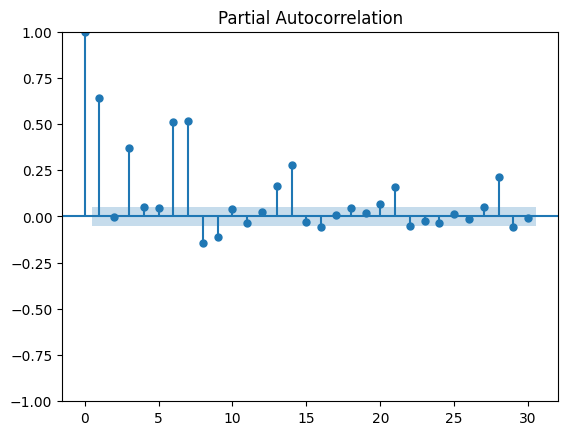

In [49]:
plot_pacf(aggregated_data['Target'], lags=30)
plt.show()

А судя по этому графику, можно сказать, что если мы будем брать авторегрессионную модель, то приоритетнее рассмотреть порядки 1 или 3, даже лучше 3, так как эти лаги имеют высокие значения partial autocorrelation, а порядок 3 даст нам более сложную модель.

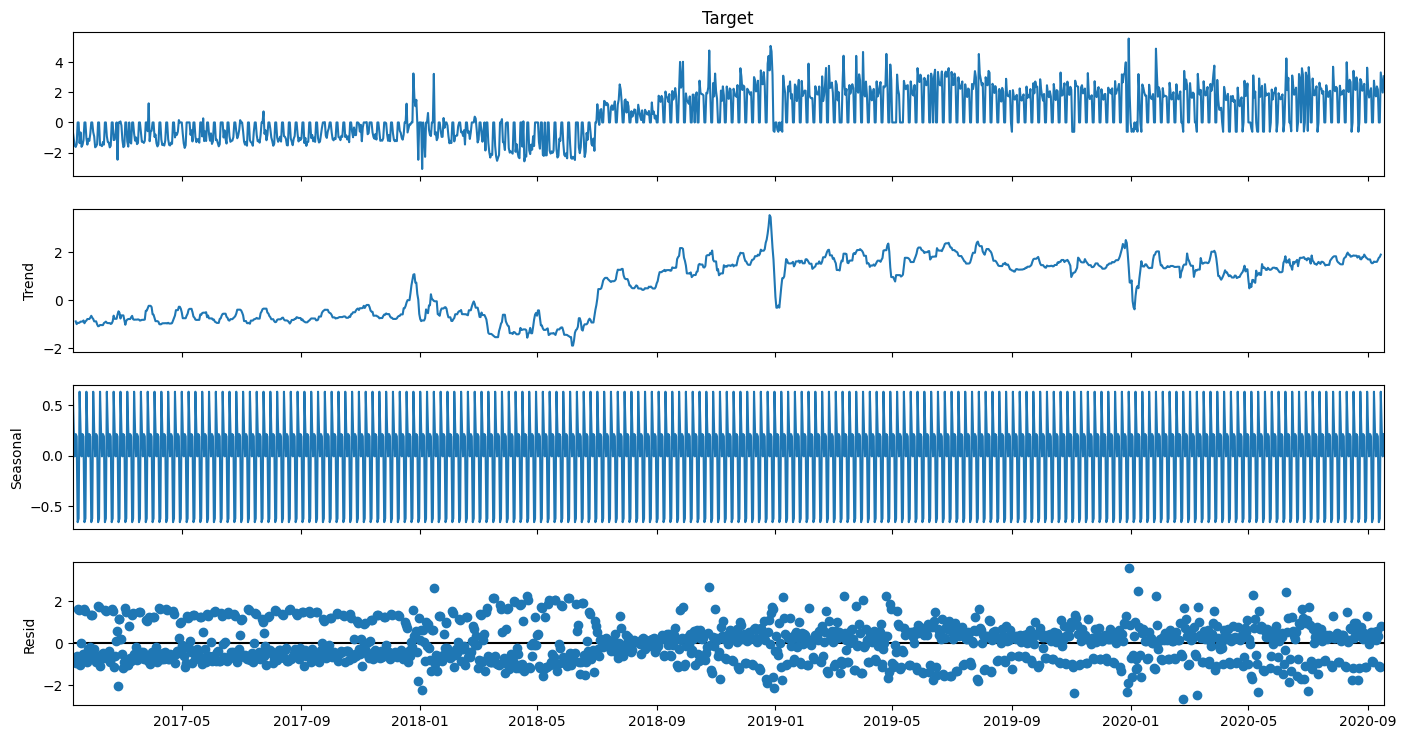

In [50]:
decomposition = seasonal_decompose(aggregated_data['Target'], model='additive')
fig = decomposition.plot()
fig.set_size_inches(16, 8)
plt.show()

Судя по Seasonal, сезонность есть, причем она явно выражена и появляется на коротких интервалах. Тренд тоже есть, после некоторого периода начинается медленный рост, заметный примерно с середины 2018 года.

На стационарность проверяем тестом Дики-Фуллера, получается, что ряд нестационарный, но это и по графику видно, честно говоря

In [51]:
adf_test = adfuller(data['Target'].dropna())
adf_test_results = {
    'Test Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Lags Used': adf_test[2],
    'Number of Observations Used': adf_test[3],
    'Critical Values': adf_test[4]
}

adf_test_results

{'Test Statistic': -0.6262592779620878,
 'p-value': 0.8649374329135215,
 'Lags Used': 31,
 'Number of Observations Used': 3877,
 'Critical Values': {'1%': -3.432037808852433,
  '5%': -2.8622857814664204,
  '10%': -2.5671669885296042}}

Вообще, вся эта информация про цикличность, сезонность, автокорреляцию дает нам понять, что лучше подавать в модель, чтобы модель в своих предсказаниях меньше ошибалась. Мы используем характеристики временного ряда и уменьшаем таким образом ошибки вроде применения не той модели или передачи не тех данных (скажем, что ряд стационарный, а он не).

## Предобработка

Разбейте данные на трейн и тест по времени. Размер теста: 0.2. Если необходимо, отнормируйте данные.

In [52]:
from sklearn.preprocessing import MinMaxScaler

In [53]:
# ваш код
train_data = aggregated_data.iloc[:int(len(aggregated_data) * 0.8)]
test_data = aggregated_data.iloc[int(len(aggregated_data) * 0.8):]
scaler = MinMaxScaler()

train_scaled = train_data.copy()
test_scaled = test_data.copy()

train_scaled['Target'] = scaler.fit_transform(train_data[['Target']])
test_scaled['Target'] = scaler.transform(test_data[['Target']])

## Простые методы

Постройте прогноз с помощью всех простых методов. Решите задачу одношагового прогнозирования.  Подсчитайте качество одношаговых прогнозов. В качестве метрики используйте SMAPE, MAE и WAPE.

$$WAPE=\frac{\sum_{t=1}^n\left|A_t-F_t\right|}{\sum_{t=1}^n\left|A_t\right|}, \quad A_t - Actual, F_t - Forecast$$

Напишите свою функцию, которая вычисляет WAPE.

В этом задании считается, что прогноз делается на одну точку тестовой выборки. После этого тренировочная выборка увеличивается на 1 точку и делается прогноз на следующую. Точносте считается как по всем получившимся прогнозам.

In [54]:
!pip install -q statsforecast

In [55]:
from sklearn.metrics import mean_absolute_error
from statsforecast.models import HistoricAverage, Naive, SeasonalNaive, RandomWalkWithDrift
from sklearn.metrics import mean_squared_error

In [56]:
# ваш код
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

In [57]:
mean_forecast_list = []
naive_forecast_list = []
seasonal_naive_forecast_list = []
drift_forecast_list = []

In [58]:
mean_model = HistoricAverage()
seasonal_naive_model = SeasonalNaive(season_length=7) #беру такой параметр, потому что по графику автокорреляции есть пики на интервалах, кратных 7 дням

In [59]:
mean_model = mean_model.fit(y=train_scaled['Target'])
seasonal_naive_model = seasonal_naive_model.fit(y=train_scaled['Target'])

Вот код для простых методов: прогноз средним, наивный прогноз, сезонный наивный прогноз, метод дрейфа.

In [60]:
for i in range(len(test_scaled)):
    mean_forecast = mean_model.predict(h=1)['mean'][0]
    naive_forecast = train_scaled.iloc[[-1]]['Target'].values[0]
    seasonal_naive_forecast = seasonal_naive_model.predict(h=1)['mean'][0]

    mean_forecast_list.append(mean_forecast)
    naive_forecast_list.append(naive_forecast)
    seasonal_naive_forecast_list.append(seasonal_naive_forecast)

    new_point = test_scaled.iloc[[i]][['Target']]
    train_scaled = pd.concat([train_scaled, new_point], ignore_index=True)

    mean_model = mean_model.fit(y=train_scaled['Target'])
    seasonal_naive_model = seasonal_naive_model.fit(y=train_scaled['Target'])

test_scaled['mean_forecast'] = mean_forecast_list
test_scaled['naive_forecast'] = naive_forecast_list
test_scaled['seasonal_naive_forecast'] = seasonal_naive_forecast_list

Еще есть метод дрейфа, с ним у меня в какой-то момент возникли сложности именно с библиотечной функцией, но там формула несложная, так что я ее закодила.

In [61]:
def drift(train):
    last_value = train[-1]
    first_value = train[0]
    drift = (last_value - first_value) / (len(train) - 1)
    forecast = last_value + drift
    return forecast

train_scaled_drift = train_scaled.copy()
for i in range(len(test_scaled)):
    train_data = train_scaled_drift['Target'].to_list()
    custom_forecast = drift(train_data)
    drift_forecast_list.append(custom_forecast)
    train_data.append(test_scaled.iloc[[i]]['Target'].values[0])


test_scaled['drift_forecast'] = drift_forecast_list

In [62]:
metrics = {
    'mean_forecast': {
        'WAPE': wape(test_scaled['Target'], test_scaled['mean_forecast']),
        'SMAPE': smape(test_scaled['Target'], test_scaled['mean_forecast']),
        'MAE': mean_absolute_error(test_scaled['Target'], test_scaled['mean_forecast'])
    },
    'naive_forecast': {
        'WAPE': wape(test_scaled['Target'], test_scaled['naive_forecast']),
        'SMAPE': smape(test_scaled['Target'], test_scaled['naive_forecast']),
        'MAE': mean_absolute_error(test_scaled['Target'], test_scaled['naive_forecast'])
    },
    'seasonal_naive_forecast': {
        'WAPE': wape(test_scaled['Target'], test_scaled['seasonal_naive_forecast']),
        'SMAPE': smape(test_scaled['Target'], test_scaled['seasonal_naive_forecast']),
        'MAE': mean_absolute_error(test_scaled['Target'], test_scaled['seasonal_naive_forecast'])
    },
    'drift_forecast': {
        'WAPE': wape(test_scaled['Target'], test_scaled['drift_forecast']),
        'SMAPE': smape(test_scaled['Target'], test_scaled['drift_forecast']),
        'MAE': mean_absolute_error(test_scaled['Target'], test_scaled['drift_forecast'])
    }
}


In [63]:
metrics_df = pd.DataFrame(metrics).T
metrics_df

,WAPE,SMAPE,MAE
mean_forecast,0.315557,33.560403,0.175318
naive_forecast,0.255240,25.993847,0.141807
seasonal_naive_forecast,0.151352,14.848067,0.084089
drift_forecast,0.377801,35.363566,0.209899


#### Визуализация

Постройте на одном графике тестовые данные и прогнозы всех моделей. Подпишите все оси.

In [64]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=test_scaled.index, y=test_scaled['Target'], mode='lines', name='Истинные значения'))

for forecast in ['mean_forecast', 'naive_forecast', 'seasonal_naive_forecast', 'drift_forecast']:
    fig.add_trace(go.Scatter(x=test_scaled.index, y=test_scaled[forecast], mode='lines', name=forecast))

fig.update_layout(
    title='Прогноз',
    xaxis_title='Дата',
    yaxis_title='Target',
    legend_title='Прогнозы',
    width=1400,
    height=500
)

fig.show()

#### Анализ остатков

Проведите анализ остатков для построенных прогнозов

Хороший метод прогнозирования дает остатки со следующими свойствами:

+ Остатки некоррелированы. Если между остатками есть корреляции, то в остатках остается информация, которая должна быть использована при вычислении прогнозов.
+ Остатки имеют нулевое среднее. Если их среднее значение отлично от нуля, то прогнозы являются смещенными.
+ Остатки имеют постоянную дисперсию. Это известно как "гомоскедастичность".
+ Остатки нормально распределены.


Ниже будет видно, что остатки не распределены нормально, в гистограммах есть хвосты, которые отличаются от нормального распределения. Между остатками есть корреляция. Прогнозы смещены для моделей среднего и метода дрейфа, так как среднее отлично от нуля.

In [65]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [66]:
# ваш код
def calculate_residuals(y_true, y_pred):
    return y_true - y_pred

test_scaled['mean_residuals'] = calculate_residuals(test_scaled['Target'], test_scaled['mean_forecast'])
test_scaled['naive_residuals'] = calculate_residuals(test_scaled['Target'], test_scaled['naive_forecast'])
test_scaled['seasonal_naive_residuals'] = calculate_residuals(test_scaled['Target'], test_scaled['seasonal_naive_forecast'])
test_scaled['drift_residuals'] = calculate_residuals(test_scaled['Target'], test_scaled['drift_forecast'])

In [67]:
def plot_residuals(residuals, title):
    plt.figure(figsize=(16, 6))
    plt.plot(residuals)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Остатки')
    plt.show()

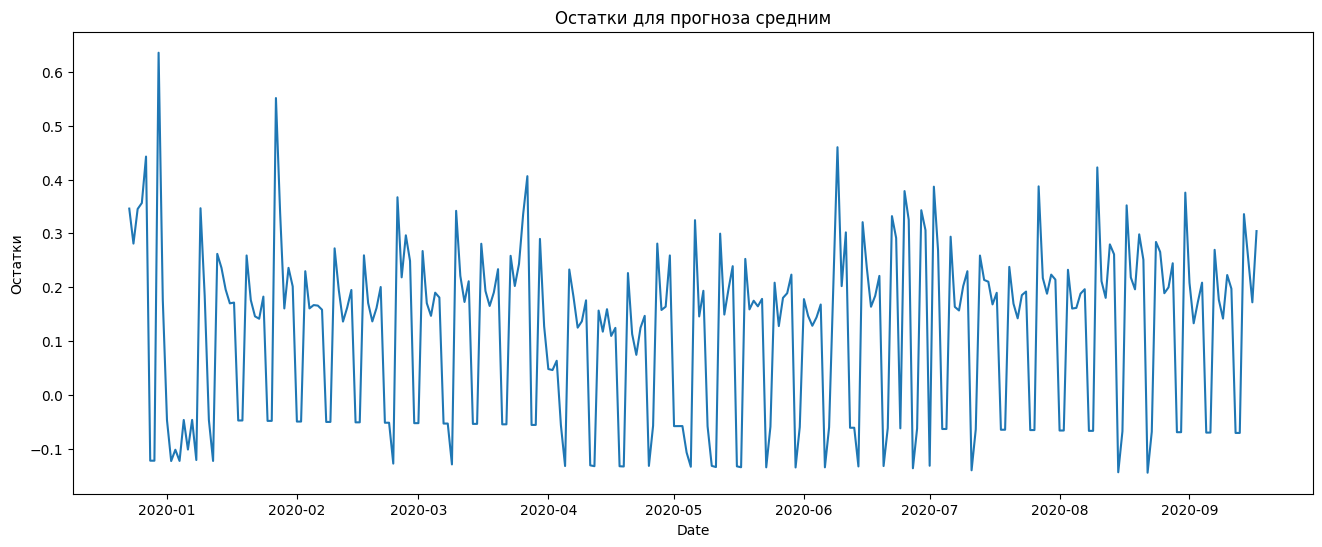

In [68]:
plot_residuals(test_scaled['mean_residuals'], 'Остатки для прогноза средним')

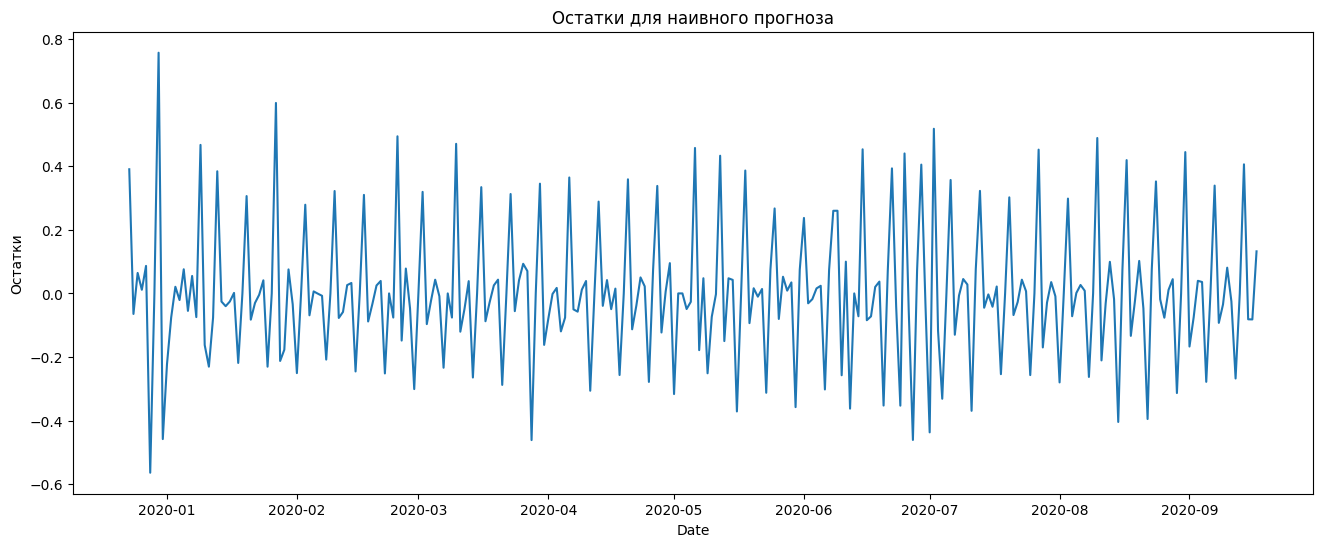

In [69]:
plot_residuals(test_scaled['naive_residuals'], 'Остатки для наивного прогноза')

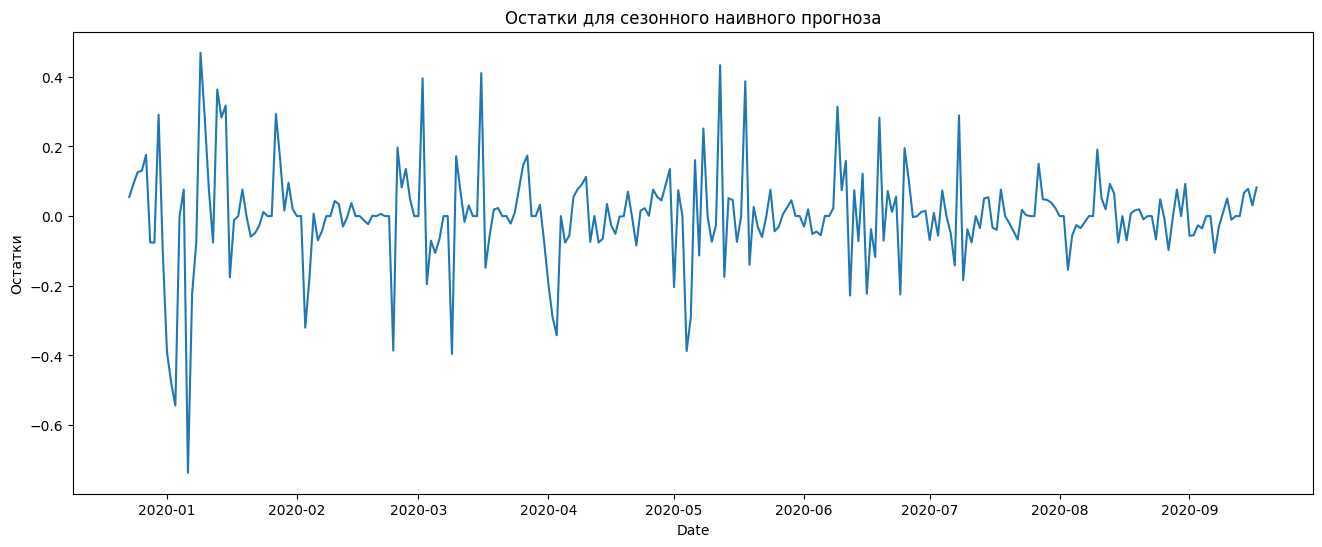

In [70]:
plot_residuals(test_scaled['seasonal_naive_residuals'], 'Остатки для сезонного наивного прогноза')

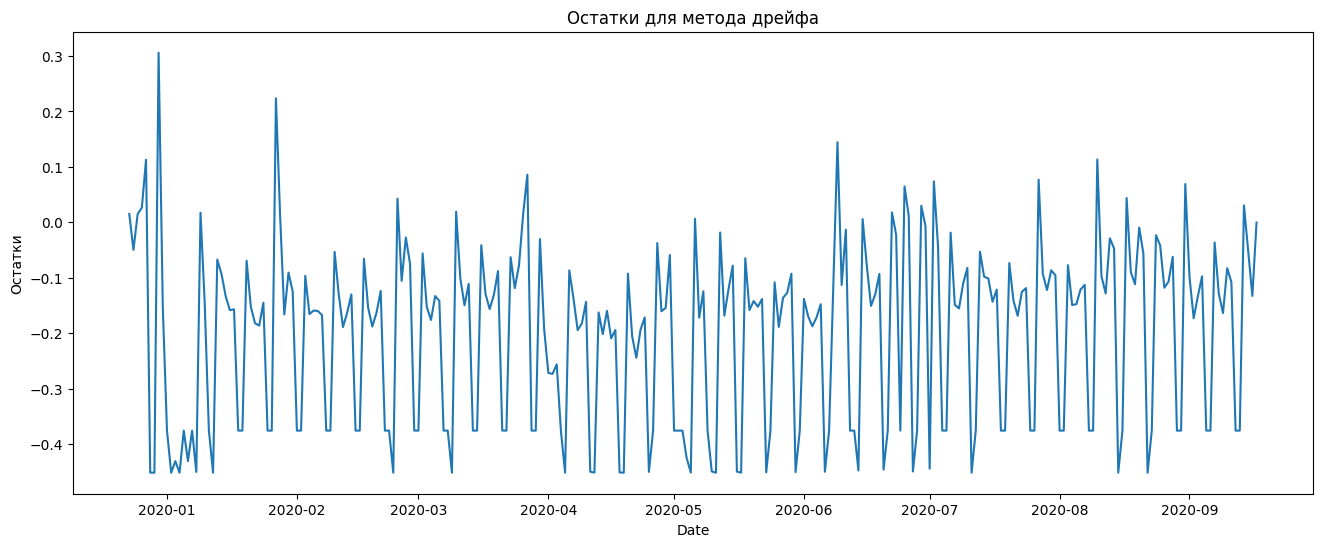

In [71]:
plot_residuals(test_scaled['drift_residuals'], 'Остатки для метода дрейфа')

In [72]:
def plot_acf_residuals(residuals, title):
    plot_acf(residuals)
    plt.title(title)
    plt.show()

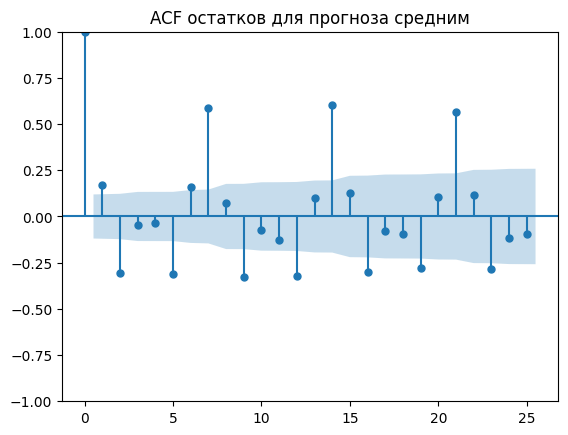

In [73]:
plot_acf_residuals(test_scaled['mean_residuals'], 'ACF остатков для прогноза средним')

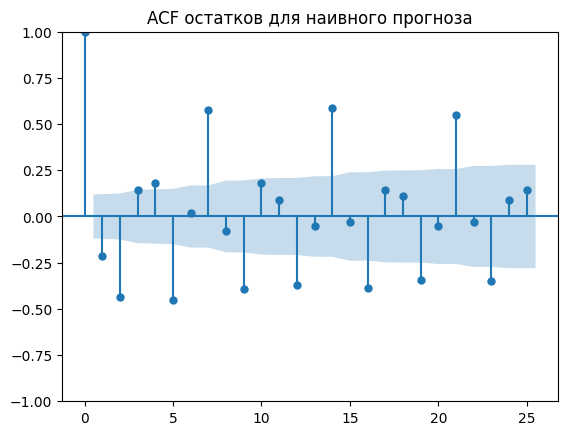

In [74]:
plot_acf_residuals(test_scaled['naive_residuals'], 'ACF остатков для наивного прогноза')

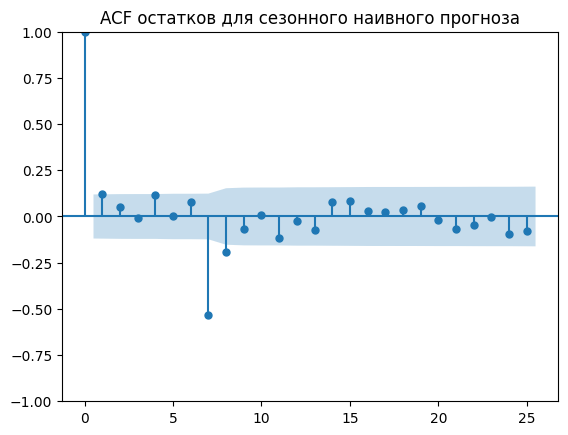

In [75]:
plot_acf_residuals(test_scaled['seasonal_naive_residuals'], 'ACF остатков для сезонного наивного прогноза')

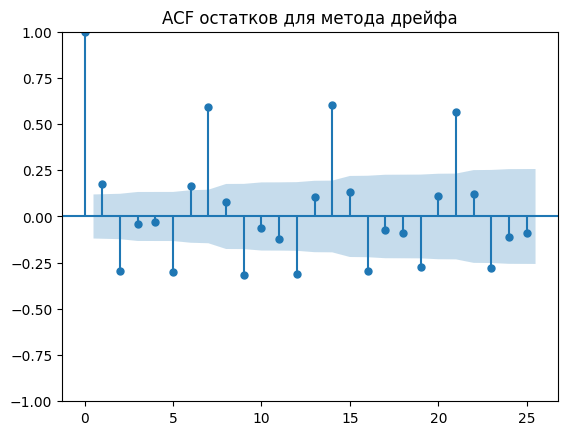

In [76]:
plot_acf_residuals(test_scaled['drift_residuals'], 'ACF остатков для метода дрейфа')

In [77]:
def plot_histogram_residuals(residuals, title):
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=20, edgecolor='k')
    plt.title(title)
    plt.xlabel('Остатки')
    plt.ylabel('Частота')
    plt.show()

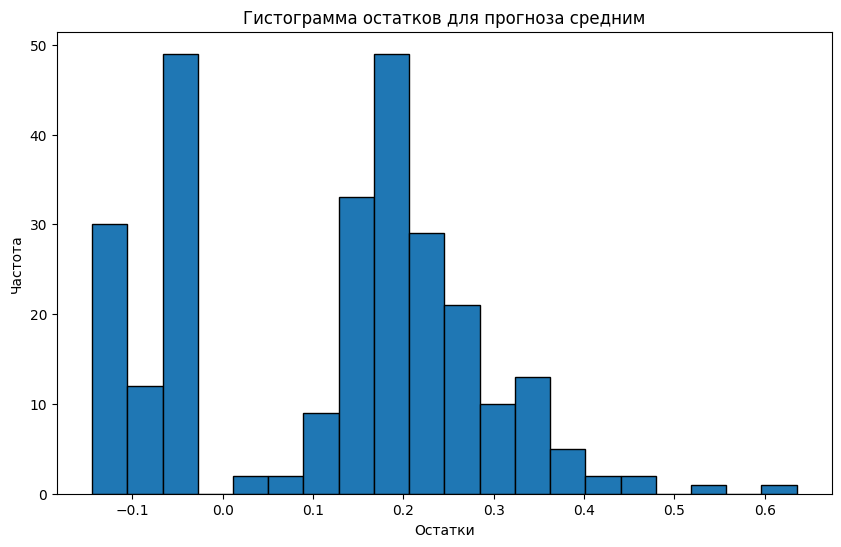

In [78]:
plot_histogram_residuals(test_scaled['mean_residuals'], 'Гистограмма остатков для прогноза средним')

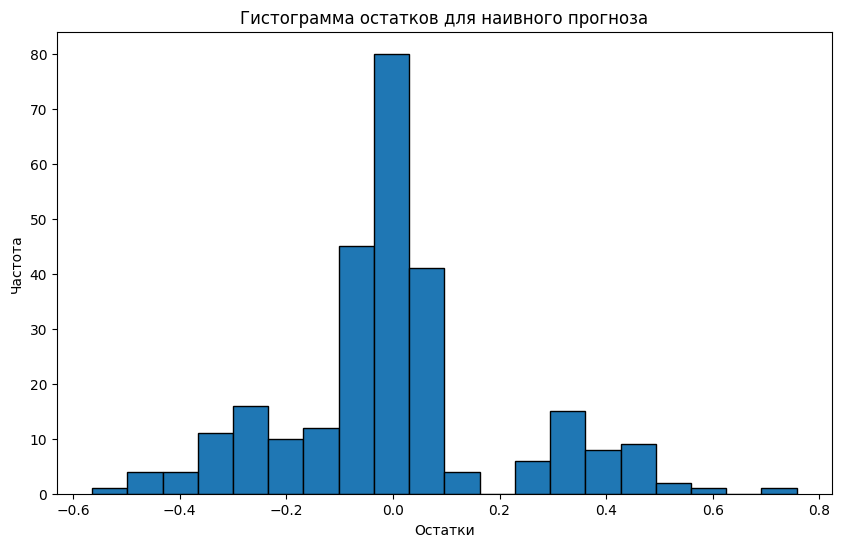

In [79]:
plot_histogram_residuals(test_scaled['naive_residuals'], 'Гистограмма остатков для наивного прогноза')

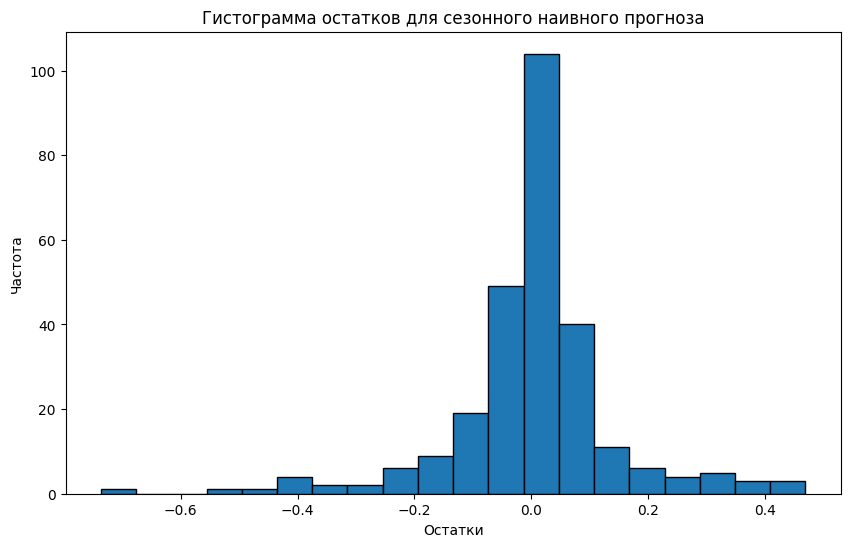

In [80]:
plot_histogram_residuals(test_scaled['seasonal_naive_residuals'], 'Гистограмма остатков для сезонного наивного прогноза')

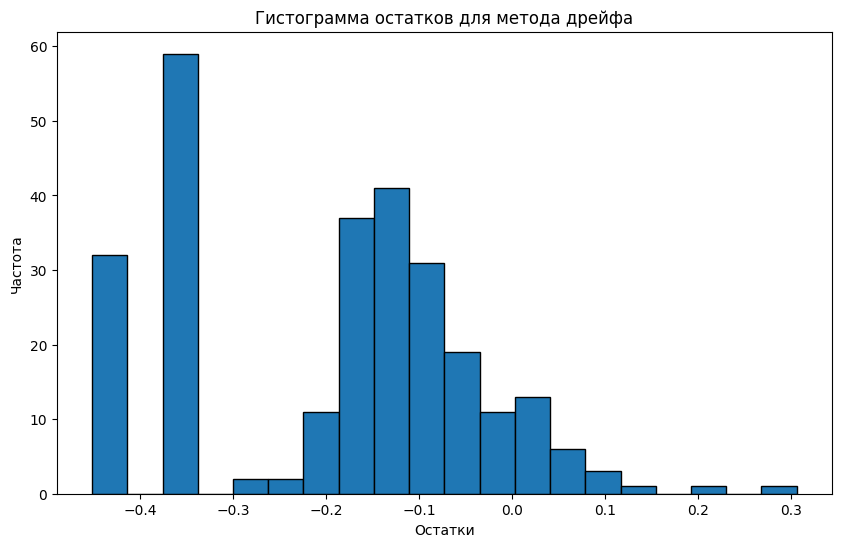

In [81]:
plot_histogram_residuals(test_scaled['drift_residuals'], 'Гистограмма остатков для метода дрейфа')

In [82]:
def ljung_box_test(name, residuals, lags=10):
    lb_test = acorr_ljungbox(residuals, lags=lags, return_df=True)
    print(f'{name}: {lb_test}')

ljung_box_test('mean_residuals', test_scaled['mean_residuals'])
ljung_box_test('naive_residuals', test_scaled['naive_residuals'])
ljung_box_test('seasonal_naive_residuals', test_scaled['seasonal_naive_residuals'])
ljung_box_test('drift_residuals', test_scaled['drift_residuals'])

mean_residuals:        lb_stat     lb_pvalue
1     7.915842  4.900378e-03
2    33.113609  6.448685e-08
3    33.724547  2.265005e-07
4    34.071376  7.204890e-07
5    60.626977  9.018714e-12
6    67.828624  1.139028e-12
7   164.521920  3.582319e-32
8   165.954124  9.078976e-32
9   196.034407  2.244958e-37
10  197.528605  5.286438e-37
naive_residuals:        lb_stat     lb_pvalue
1    12.297590  4.535435e-04
2    64.765402  8.637175e-15
3    70.574977  3.214636e-15
4    79.411033  2.321489e-16
5   136.526722  9.789304e-28
6   136.654676  5.089599e-27
7   229.335416  6.870089e-46
8   230.959197  1.855848e-45
9   274.805178  5.692121e-54
10  284.189020  3.400537e-55
seasonal_naive_residuals:        lb_stat     lb_pvalue
1     4.152774  4.156637e-02
2     4.831812  8.928642e-02
3     4.860732  1.822837e-01
4     8.615288  7.146868e-02
5     8.619619  1.252325e-01
6    10.377494  1.096288e-01
7    89.581362  1.508037e-16
8    99.919509  4.433972e-18
9   101.236704  8.843530e-18
10  101.25459

большие значения  Q∗  указывают на то, что автокорреляции не являются результатом серии белого шума. и здесь так и есть, если мы посмотрим на значения.

In [83]:
test_scaled['mean_residuals'].mean(), test_scaled['naive_residuals'].mean(), test_scaled['seasonal_naive_residuals'].mean(), test_scaled['drift_residuals'].mean()

(0.11943799793896956,
 0.0013898867553017744,
 0.0007345379893783169,
 -0.19819746748374492)

#### Преобразования

Дополнительно можете произвести на трейне обратимые преобразования, которые сочтёте необходимыми (Box-Cox, детрендирование и т.п.). Увеличивается ли точность прогнозов при использовании преобразований?

In [84]:
# импортируем библиотеки numpy, pandas, bottleneck
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# отключим предупреждения
import warnings
warnings.filterwarnings('ignore')

Я решила потестить Box-Cox

In [85]:
from scipy import stats

In [86]:
# ваш код
def boxcox_transform(series):
    transformed, lambda_ = stats.boxcox(series)
    return transformed, lambda_


train_data = aggregated_data.iloc[:int(len(aggregated_data) * 0.8)]
test_data = aggregated_data.iloc[int(len(aggregated_data) * 0.8):]
shift = abs(train_data['Target'].min()) + 1
train_values = train_data['Target'] + shift
train_data_boxcox = train_data.copy()
train_data_boxcox['Target'], lambda_ = boxcox_transform(train_values)

Вот так вот будет выглядеть обратное преобразование, если нужно

In [87]:
def boxcox_inverse(y, lambda_, shift):
    y = np.array(y)
    if lambda_ == 0:
        return np.exp(y) - shift
    else:
        return np.power(y * lambda_ + 1, 1 / lambda_) - shift

Посмотрим на то, как штука ведет себя для наивного прогноза.

In [88]:
pred_box = []
train_old = train_data_boxcox['Target'].tolist()

for t in range(len(test_data)):
    new_point = train_old[-1]
    pred_box.append(new_point)
    obs = test_data['Target'].iloc[t]
    obs_transformed = stats.boxcox(obs + shift, lmbda=lambda_)
    train_old.append(obs_transformed)

In [89]:
pred_inv = boxcox_inverse(pred_box, lambda_, shift)

In [90]:
print('WAPE', wape(test_data['Target'], pred_inv))
print('SMAPE', smape(test_data['Target'], pred_inv))
print('MAE', mean_absolute_error(test_data['Target'], pred_inv))

WAPE 0.7285225410048036
SMAPE 103.34658518529321
MAE 1.1548579724111112


Я улучшения не заметила особо. Стало хуже((

#### Повтор препроцессинга

Повторите разбиение на трейн и тест. Возьмём в качестве теста последние 50 наблюдений. Соответственно, горизонт прогнозирования будет равен 50.

In [91]:
# ваш код
train_data = aggregated_data.iloc[:len(aggregated_data) - 50]
test_data = aggregated_data.iloc[len(aggregated_data) - 50:]

#### Рекурсивная стратегия

Рекурсивную стратегию необходимо написать вручную! За бонусные баллы можете сравнить свои результаты с функциями, реализованными в одной из библиотек.

Реализуйте рекурсивное прогнозирование на 50 шагов для модели дрейфа и глобального среднего.

In [92]:
# ваш код
def drift_recursive_forecast(train, steps):
    forecasts = []
    for _ in range(steps):
        last_value = train[-1]
        first_value = train[0]
        drift = (last_value - first_value) / (len(train) - 1)
        forecast = last_value + drift
        forecasts.append(forecast)
        train.append(forecast)
    return np.array(forecasts)

def mean_recursive_forecast(train, steps):
    forecasts = []
    for _ in range(steps):
        mean_forecast = np.mean(train)
        forecasts.append(mean_forecast)
        train.append(mean_forecast)
    return np.array(forecasts)

In [93]:
drift_forecast = drift_recursive_forecast(train_data['Target'].copy().to_list(), 50)
mean_forecast = mean_recursive_forecast(train_data['Target'].copy().to_list(), 50)

test_data['drift_forecast_rec'] = drift_forecast
test_data['mean_forecast_rec'] = mean_forecast

#### Прямая стратегия

Прямую стратегию необходимо написать вручную!

Реализуйте прямое прогнозирование на 50 шагов для всех простых моделей.

In [94]:

def drift_direct_forecast(train, steps):
    last_value = train[-1]
    first_value = train[0]
    drift = (last_value - first_value) / (len(train) - 1)
    forecast = [last_value + drift * (i + 1) for i in range(steps)]
    return np.array(forecast)

def mean_direct_forecast(train, steps):
    mean_forecast = np.mean(train)
    forecast = [mean_forecast for _ in range(steps)]
    return np.array(forecast)

In [95]:
drift_forecast = drift_direct_forecast(train_data['Target'].copy().to_list(), 50)
mean_forecast = mean_direct_forecast(train_data['Target'].copy().to_list(), 50)

test_data['drift_forecast_direct'] = drift_forecast
test_data['mean_forecast_direct'] = mean_forecast

#### Стратегия DirRec

Стратегию необходимо написать вручную!

Реализуйте смешанное прогнозирование на 50 шагов для модели дрейфа и глобального среднего.

In [96]:
# ваш код
def dirrec_drift_forecast(train, steps):
    forecast = []
    for i in range(steps):
        last_value = train[-1]
        first_value = train[0]
        drift = (last_value - first_value) / (len(train) - 1)
        new_value = last_value + drift
        forecast.append(new_value)
        train.append(new_value)
    return np.array(forecast)

def dirrec_mean_forecast(train, steps):
    forecast = []
    for i in range(steps):
        mean_forecast = np.mean(train)
        forecast.append(mean_forecast)
        train.append(mean_forecast)
    return np.array(forecast)

drift_forecast = dirrec_drift_forecast(train_data['Target'].copy().to_list(), 50)
mean_forecast = dirrec_mean_forecast(train_data['Target'].copy().to_list(), 50)

test_data['drift_forecast_dirrec'] = drift_forecast
test_data['mean_forecast_dirrec'] = mean_forecast

#### Результаты

Визуализируйте прогнозы стратегий и тестовые данные на одном графике. Подсчитайте WAPE прогнозов. Какая оказалась лучше? Как вы думаете, почему?

In [97]:
test_data.columns

Index(['Target', 'drift_forecast_rec', 'mean_forecast_rec',
       'drift_forecast_direct', 'mean_forecast_direct',
       'drift_forecast_dirrec', 'mean_forecast_dirrec'],
      dtype='object')

In [98]:
# ваш код
fig = go.Figure()

fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Target'], mode='lines', name='Target'))

for forecast in ['drift_forecast_dirrec', 'mean_forecast_dirrec',
                 'drift_forecast_rec', 'mean_forecast_rec',
                 'drift_forecast_direct', 'mean_forecast_direct']:
    fig.add_trace(go.Scatter(x=test_data.index, y=test_data[forecast], mode='lines', name=forecast))

fig.update_layout(
    title='Прогнозы стратегий и тестовые данные',
    xaxis_title='Индекс',
    yaxis_title='Значения',
    legend_title='Модели',
    width=800,
    height=500
)

fig.show()

In [99]:
wape_drift_dirrec = wape(test_data['Target'], test_data['drift_forecast_dirrec'])
wape_mean_dirrec = wape(test_data['Target'], test_data['mean_forecast_dirrec'])
wape_drift_rec = wape(test_data['Target'], test_data['drift_forecast_rec'])
wape_mean_rec = wape(test_data['Target'], test_data['mean_forecast_rec'])
wape_drift_direct = wape(test_data['Target'], test_data['drift_forecast_direct'])
wape_mean_direct = wape(test_data['Target'], test_data['mean_forecast_direct'])

print(f"WAPE Drift DirRec: {wape_drift_dirrec}")
print(f"WAPE Mean DirRec: {wape_mean_dirrec}")
print(f"WAPE Drift Rec: {wape_drift_rec}")
print(f"WAPE Mean Rec: {wape_mean_rec}")
print(f"WAPE Drift Direct: {wape_drift_direct}")
print(f"WAPE Mean Direct: {wape_mean_direct}")

WAPE Drift DirRec: 0.5241249591656092
WAPE Mean DirRec: 0.868668056766146
WAPE Drift Rec: 0.5241249591656092
WAPE Mean Rec: 0.868668056766146
WAPE Drift Direct: 0.5241249591656091
WAPE Mean Direct: 0.8686680567661459


Модель дрейфа лучше справляется с данными, так как она учитывает наклон и изменения тренда временного ряда, и это позволяет ей делать более точные прогнозы на основе последних наблюдений.

## ETS модель (5 баллов)

Загрузите данные `atm_hw_1.csv`

#### О задании


Представьте себе стандартный банкомат, который работает только на выдачу. Его нужно периодически пополнять наличностью, чтобы он функционировал непрерывно. Однако выезд инкассаторов является делом хлопотным и недешёвым, так что хотелось бы не гонять их лишний раз заполнять наполовину полный банкомат. Хотелось бы научиться предсказывать спрос людей на наличность в банкомате, чтобы можно было предсказывать время, когда количество денег в банкомате снизится до минимально допустимой величины. Этим мы и займёмся. Для простоты возьмём один конкретный банкомат. Нам доступны объёмы выдачи в банкомате по дням.Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Опишите, как сделанные вами наблюдения помогут построить модель.

Взгляните на ряд и опишите, какие из вариантов ETS-модели подошли бы под наши данные. Сформируйте сетку параметров для моделей-кандидатов. Кратко поясните каждую опцию, которую вы включаете в сетку, основываясь на визуальном анализе.

In [100]:
# ваш код
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing as ETSModel
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [101]:
data = pd.read_csv('atm_hw_1.csv')
data['Date'] = pd.to_datetime(data['Unnamed: 0'])
data.set_index('Date', inplace=True)

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 986 entries, 2015-01-01 to 2017-09-12
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  986 non-null    object 
 1   target      986 non-null    float64
dtypes: float64(1), object(1)
memory usage: 23.1+ KB


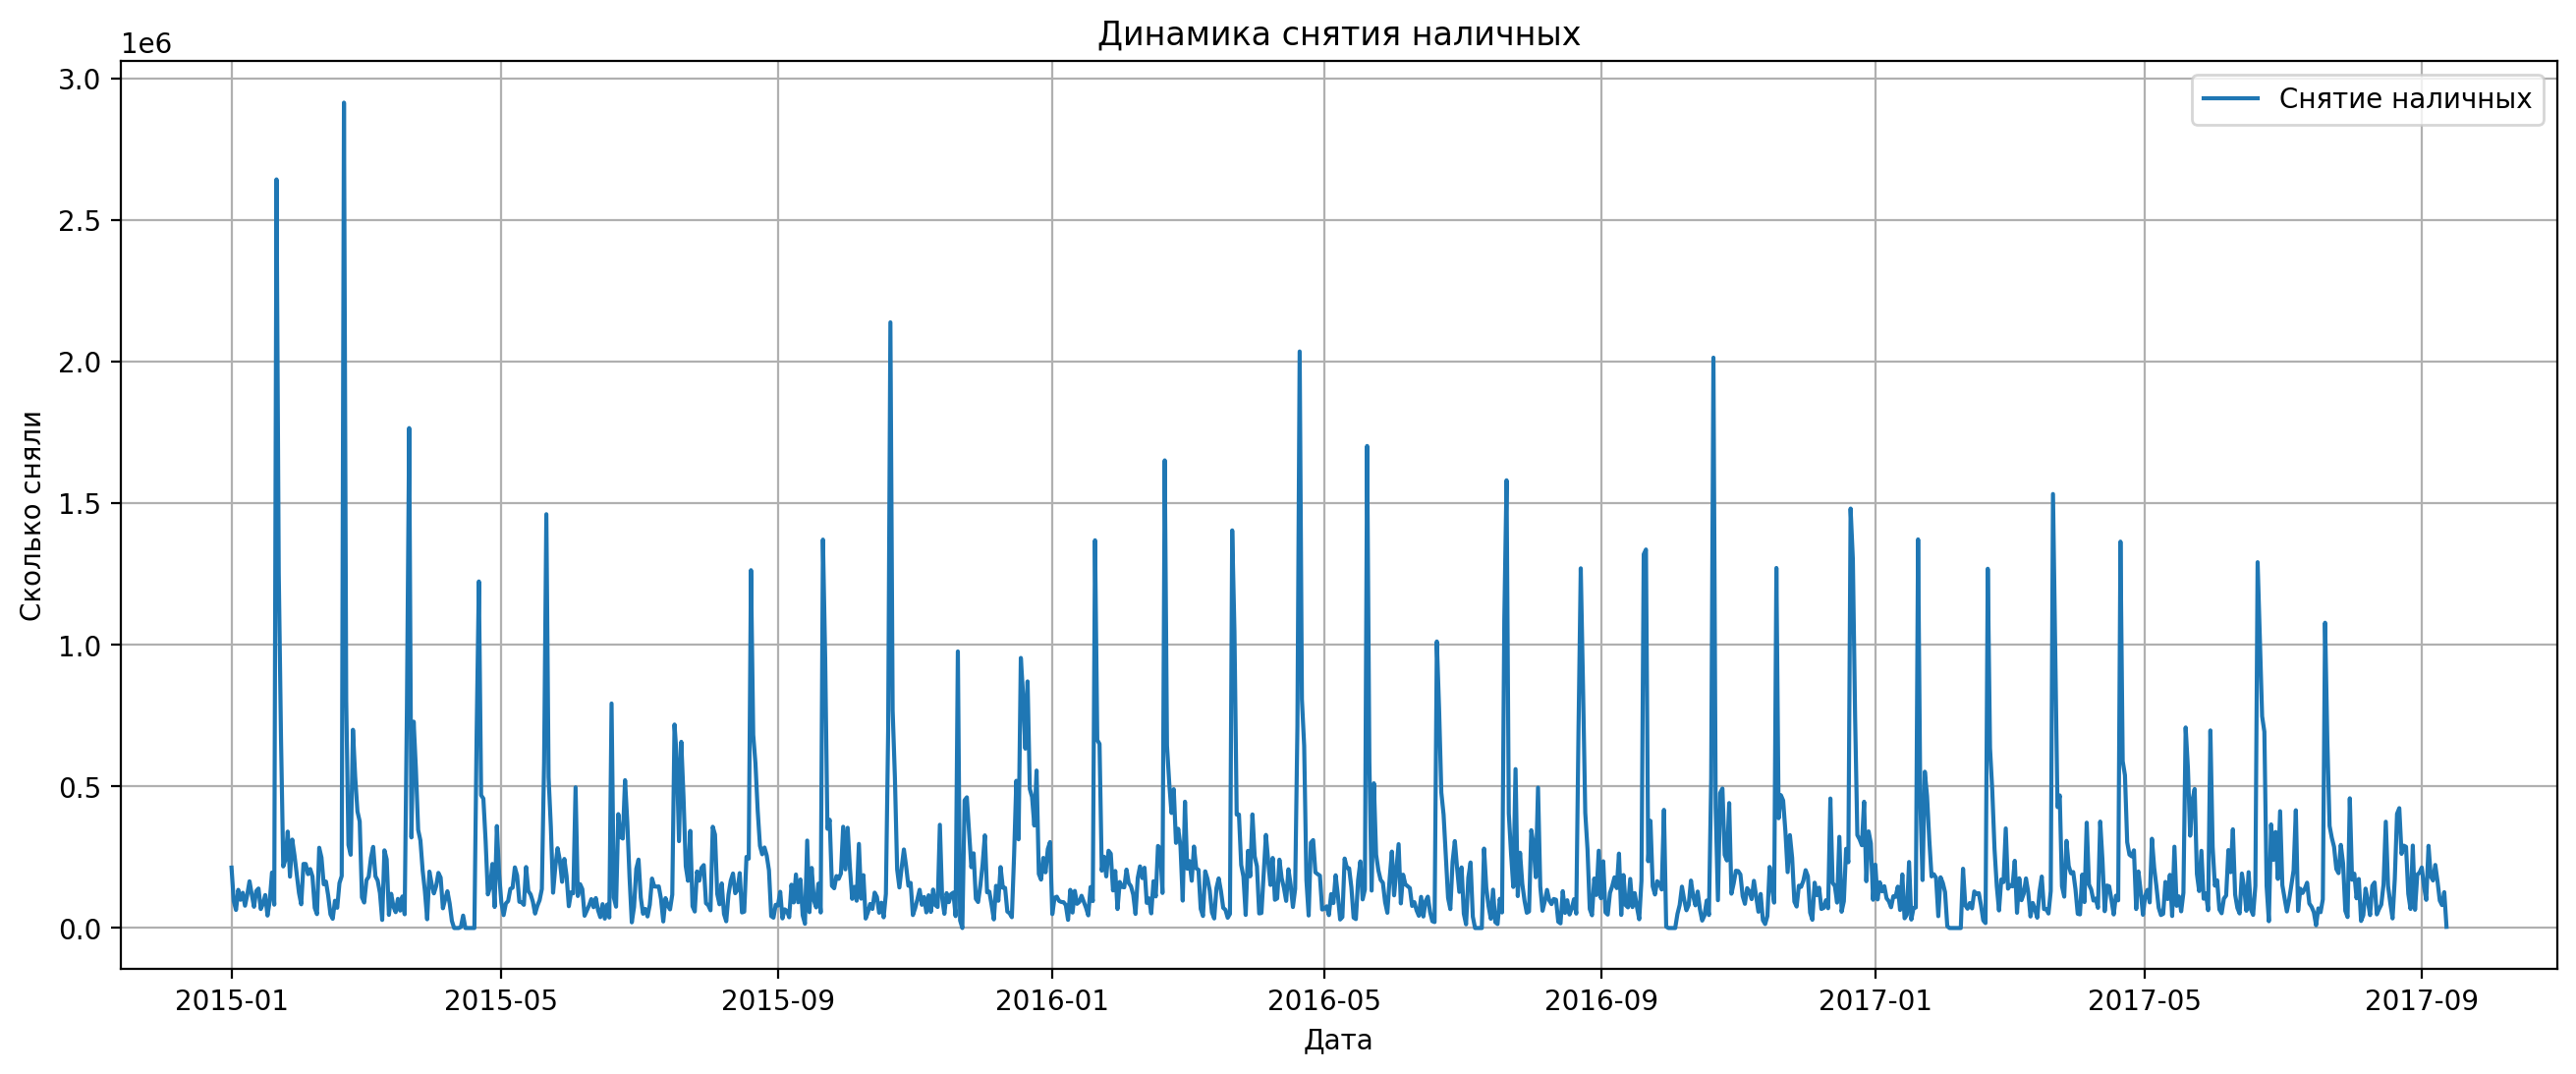

In [103]:
plt.figure(figsize=(16, 6))
plt.plot(data.index, data['target'], label='Снятие наличных')
plt.title('Динамика снятия наличных')
plt.xlabel('Дата')
plt.ylabel('Сколько сняли')
plt.legend()
plt.grid(True)
plt.show()

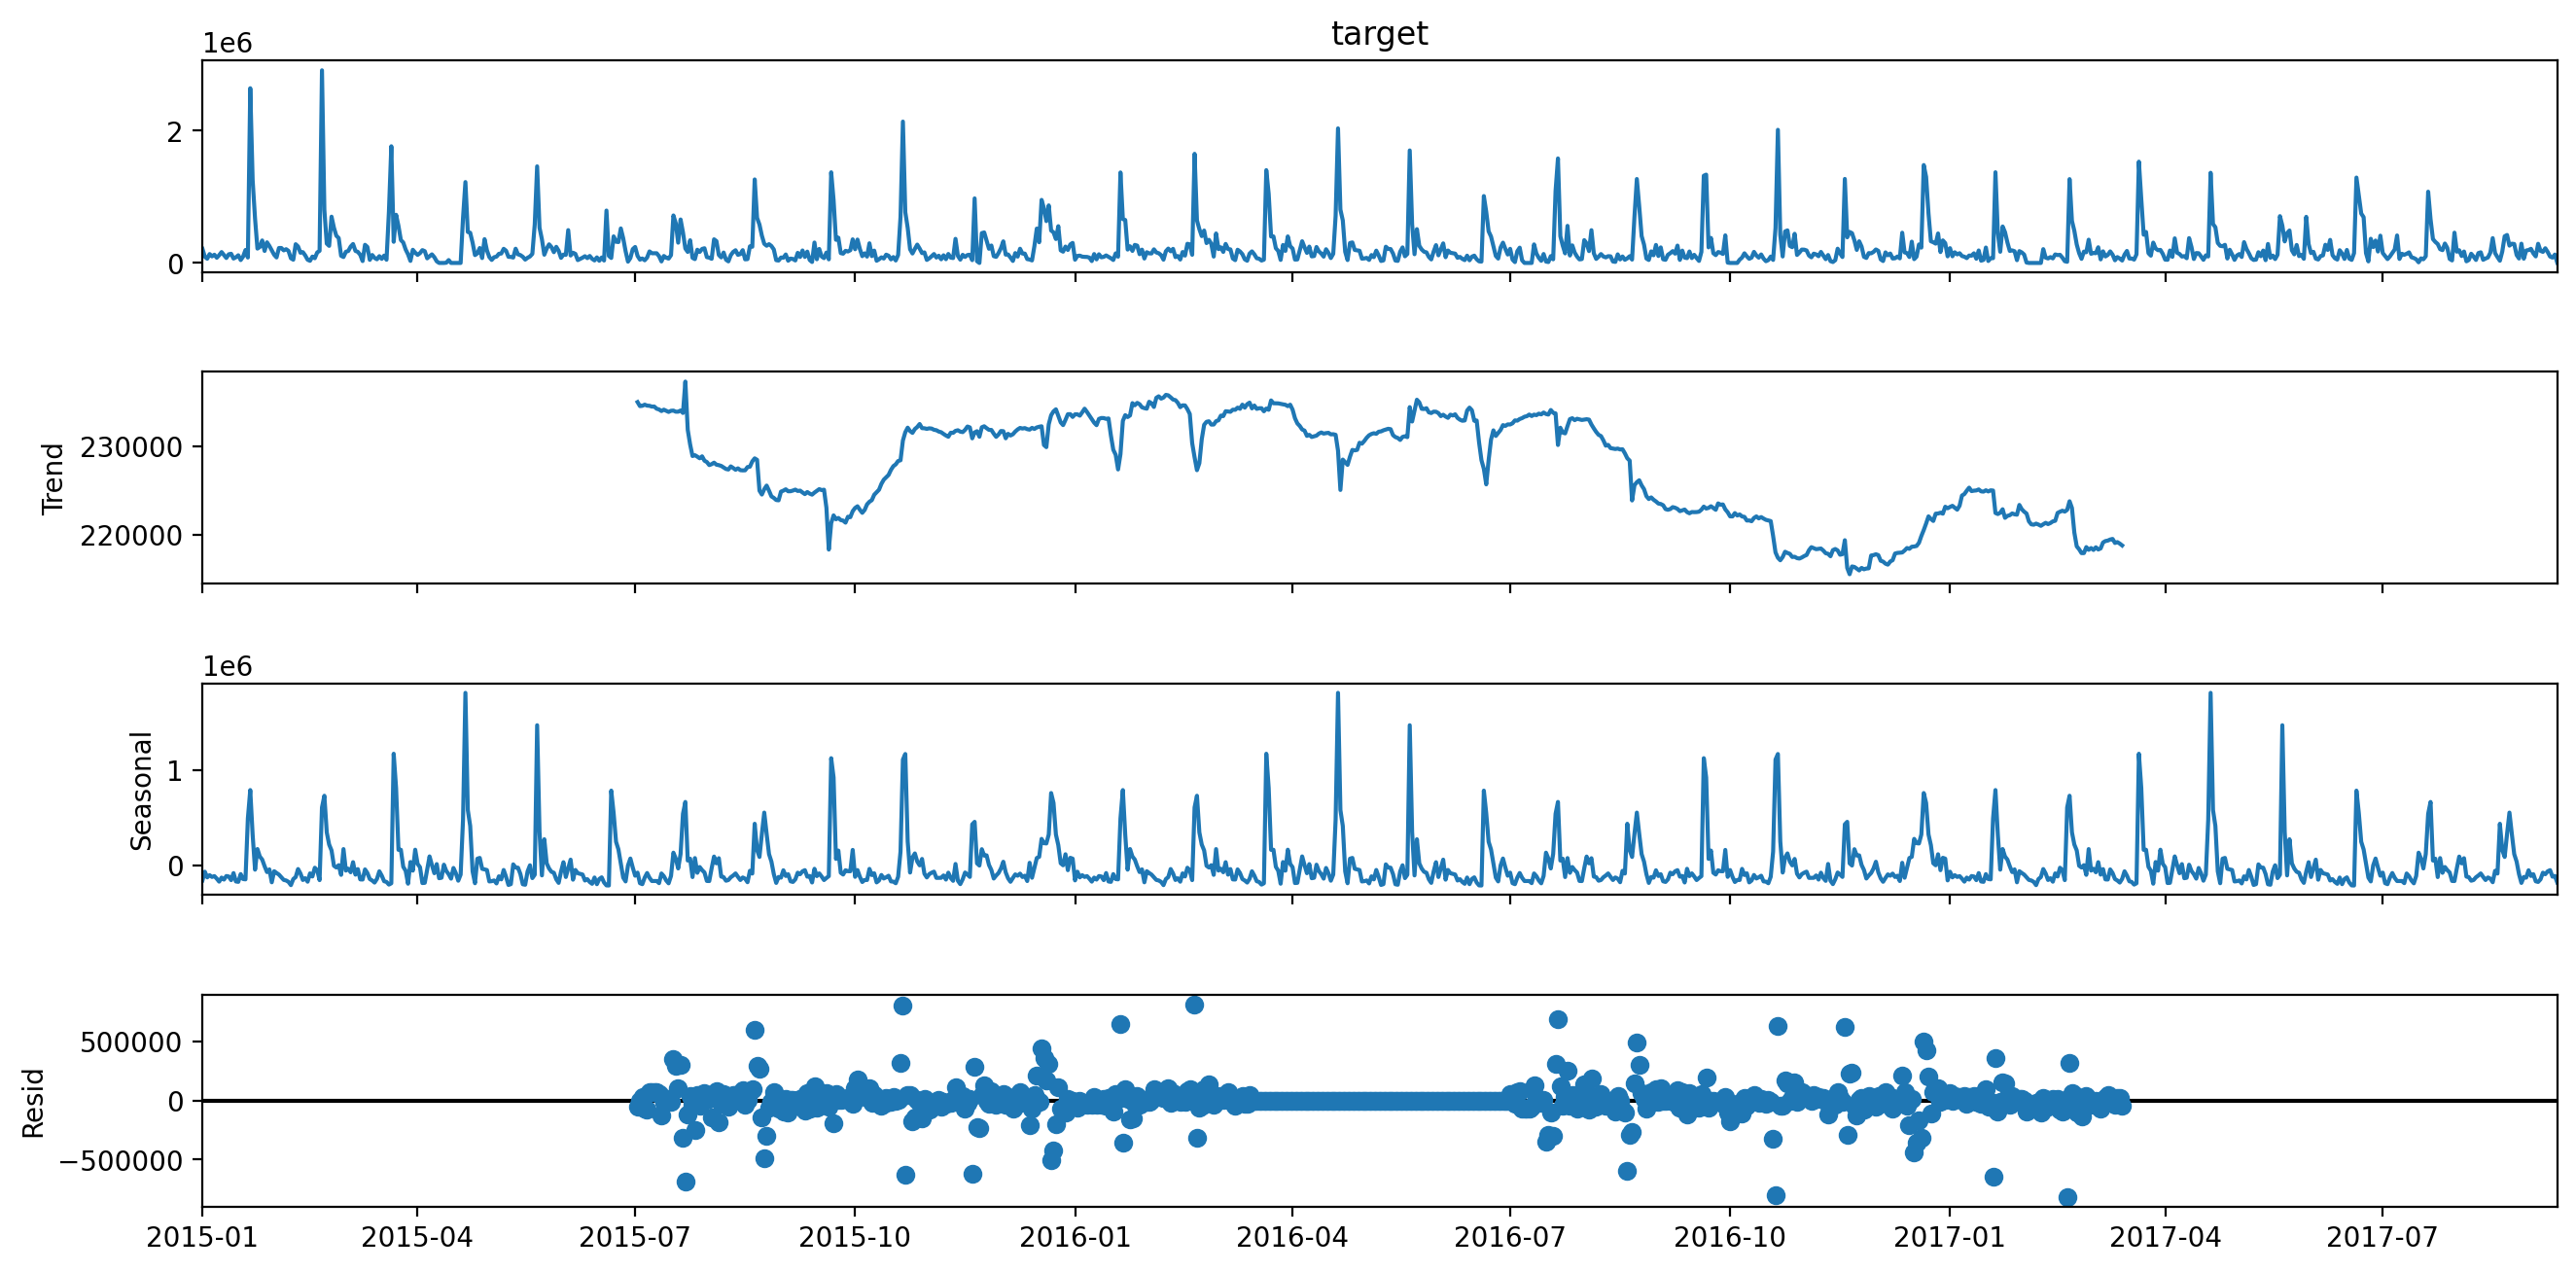

In [104]:
decomposition = seasonal_decompose(data['target'], model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(15, 7)
plt.show()

<Figure size 1000x600 with 0 Axes>

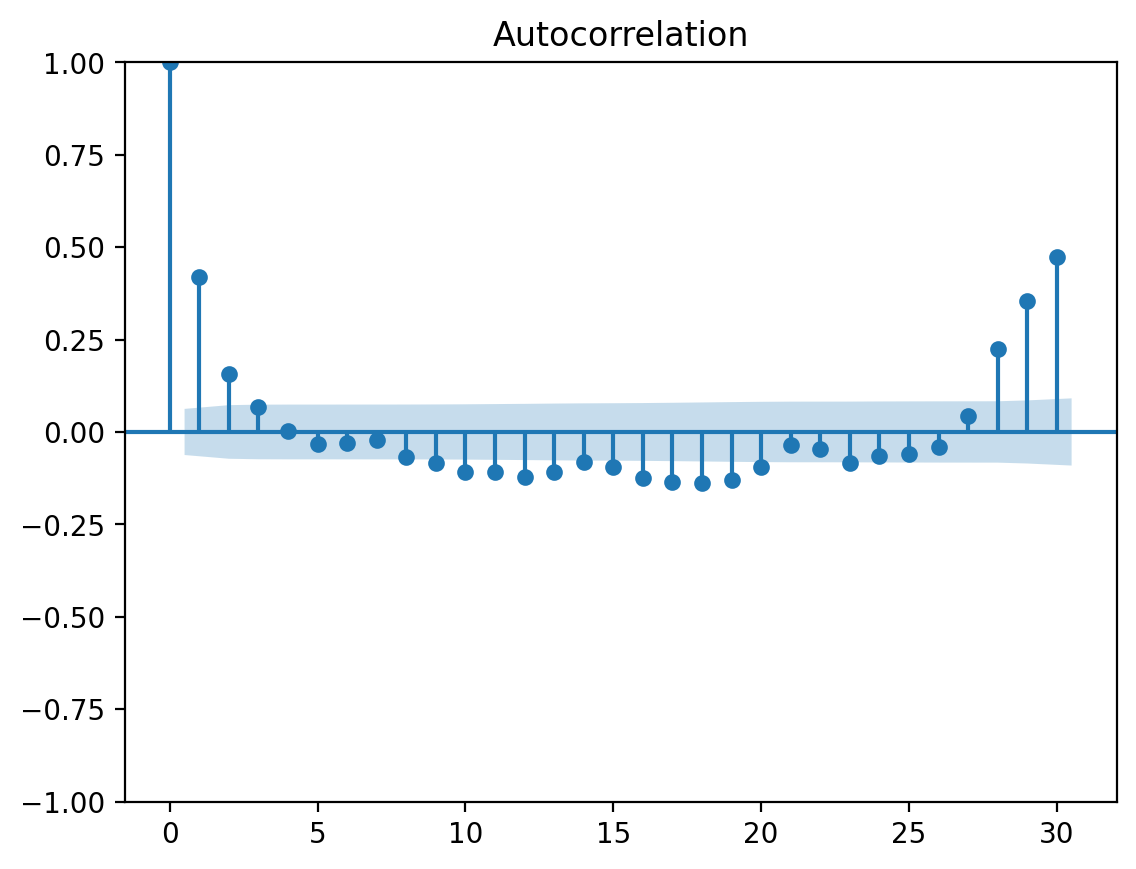

In [105]:
plt.figure(figsize=(10, 6))
plot_acf(data['target'], lags=30)
plt.show()

<Figure size 1000x600 with 0 Axes>

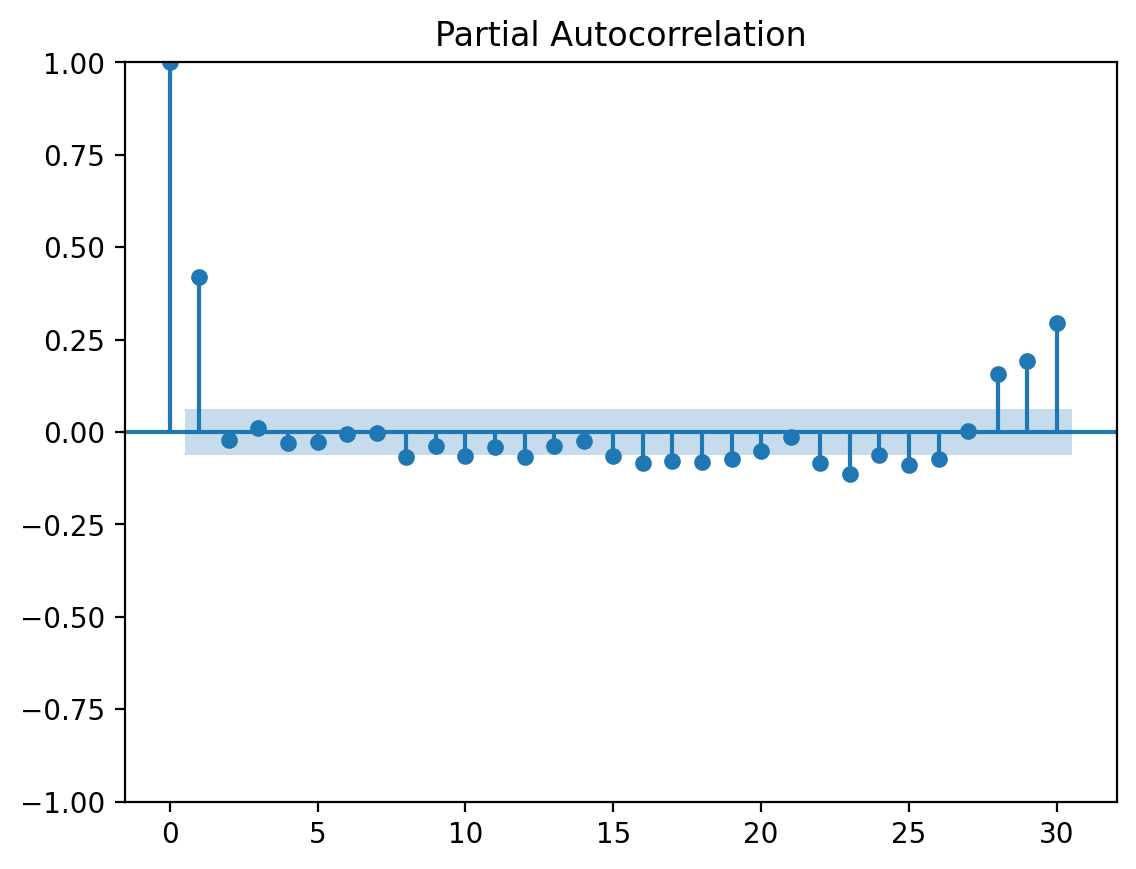

In [106]:
plt.figure(figsize=(10, 6))
plot_pacf(data['target'], lags=30)
plt.show()

На графиках декомпозиции временного ряда видно, у ряда есть сезонность с регулярными пиками и снижениями, а также некоторый нисходящий тренд в последние периоды. Остатки выглядят случайными.

Графики автокорреляции и частичной автокорреляции подтверждают наличие сезонности с лагами, особенно на 24-30, это говорит о возможной ежемесячной сезонности в данных.

Про полезность такой информации говорила в первой части.

Вот тут вот сетка параметров

In [107]:
param_grid = {
    'error': ['add', 'mul'],
    'trend': ['add', None],
    'seasonal': ['add', 'mul'],
    'seasonal_periods': [7, 30, 365]
}

На основе визуального анализа временного ряда можно сделать вывод, что данные демонстрируют регулярную сезонность и потенциальный тренд. Поэтому в ETS-модели подойдут параметры, которые учитывают аддитивные и мультипликативные ошибки, аддитивный тренд и как аддитивную, так и мультипликативную сезонность, с различными периодами сезонности (неделя, месяц, год). И параметры выбраны соответственно в сетку

#### Предобработка данных

Разбейте данные на трейн и тест. Размер теста: последние 50 дней.

Как легко заметить, данные неотрицательны. Но на случай использования мультипликативных моделей рекомендуется децентрировать трейн в положительную полуось. Дополнительно можете произвести на трейне обратимые преобразования, которые сочтёте необходимыми (Box-Cox, детрендирование и т.п.).

Определите период сезонной компоненты (не сами, а с помощью кода).

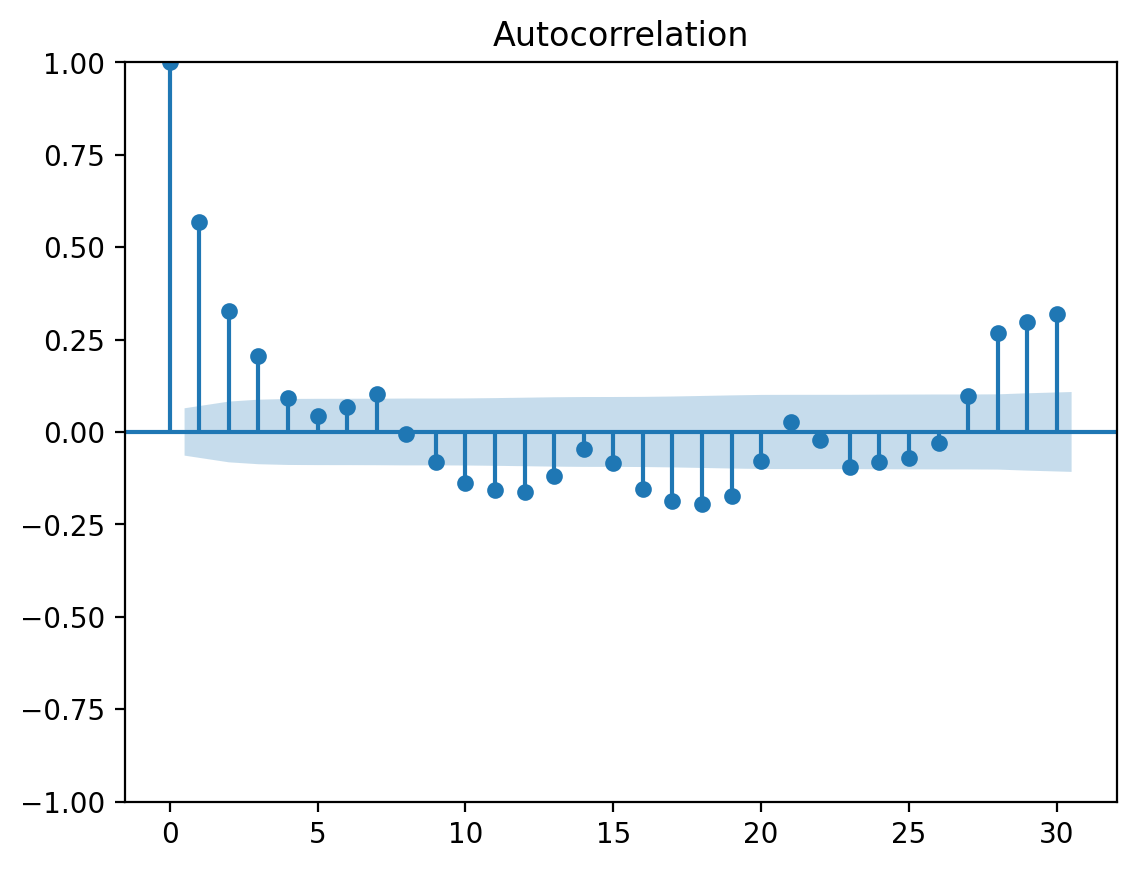

In [108]:
# ваш код
train_data = data.iloc[:-50]
test_data = data.iloc[-50:]

train_data['target'] = train_data['target'] + abs(train_data['target'].min()) + 1

train_data['target'], lam = stats.boxcox(train_data['target'])

plot_acf(train_data['target'], lags=30)
plt.show()

#### Кросс-валидация

С помощью кросс-валидации выберите наилучшую по MAE ETS-модель. Обучите её на всём трейне и спрогнозируйте на тест.

In [109]:
from sklearn.model_selection import ParameterGrid

In [111]:
# ваш код
best_score = float('inf')
best_params = None
tscv = TimeSeriesSplit(n_splits=5)
for params in ParameterGrid(param_grid):
    error = params['error']
    trend = params['trend']
    seasonal = params['seasonal']
    seasonal_periods = params['seasonal_periods']

    if seasonal is None:
        seasonal_periods = None

    if 'mul' in [trend, seasonal]:
        if (train_data['target'] <= 0).any():
            continue

    cv_scores = []

    for train_index, val_index in tscv.split(train_data):
        X_train_cv = train_data.iloc[train_index]['target']
        X_val_cv = train_data.iloc[val_index]['target']

        try:
            model = ExponentialSmoothing(
                X_train_cv,
                trend=trend,
                seasonal=seasonal,
                seasonal_periods=seasonal_periods,
                use_boxcox=False
            )
            model_fit = model.fit(optimized=True, remove_bias=True)
            y_pred = model_fit.forecast(len(X_val_cv))
            score = mean_absolute_error(X_val_cv, y_pred)
            cv_scores.append(score)
        except Exception as e:
            continue

    if cv_scores:
        avg_score = np.mean(cv_scores)
        if avg_score < best_score:
            best_score = avg_score
            best_params = params

if best_params is not None:
    best_model = ExponentialSmoothing(
        train_data['target'],
        trend=best_params['trend'],
        seasonal=best_params['seasonal'],
        seasonal_periods=best_params['seasonal_periods'],
        use_boxcox=False
    ).fit(optimized=True, remove_bias=True)

    predictions = best_model.forecast(steps=len(test_data))
    mae = mean_absolute_error(test_data['target'], predictions)
    print(f"Best params: {best_params}, MAE: {mae}")


Best params: {'error': 'add', 'seasonal': 'add', 'seasonal_periods': 7, 'trend': None}, MAE: 166835.3393090916


In [112]:
test_pred = boxcox_inverse(predictions, lam, shift)

### Анализ остатков

Проведите анализ остатков для построенных прогнозов.

In [115]:
# ваш код
resid = test_data['target'] - test_pred

<Figure size 1400x600 with 0 Axes>

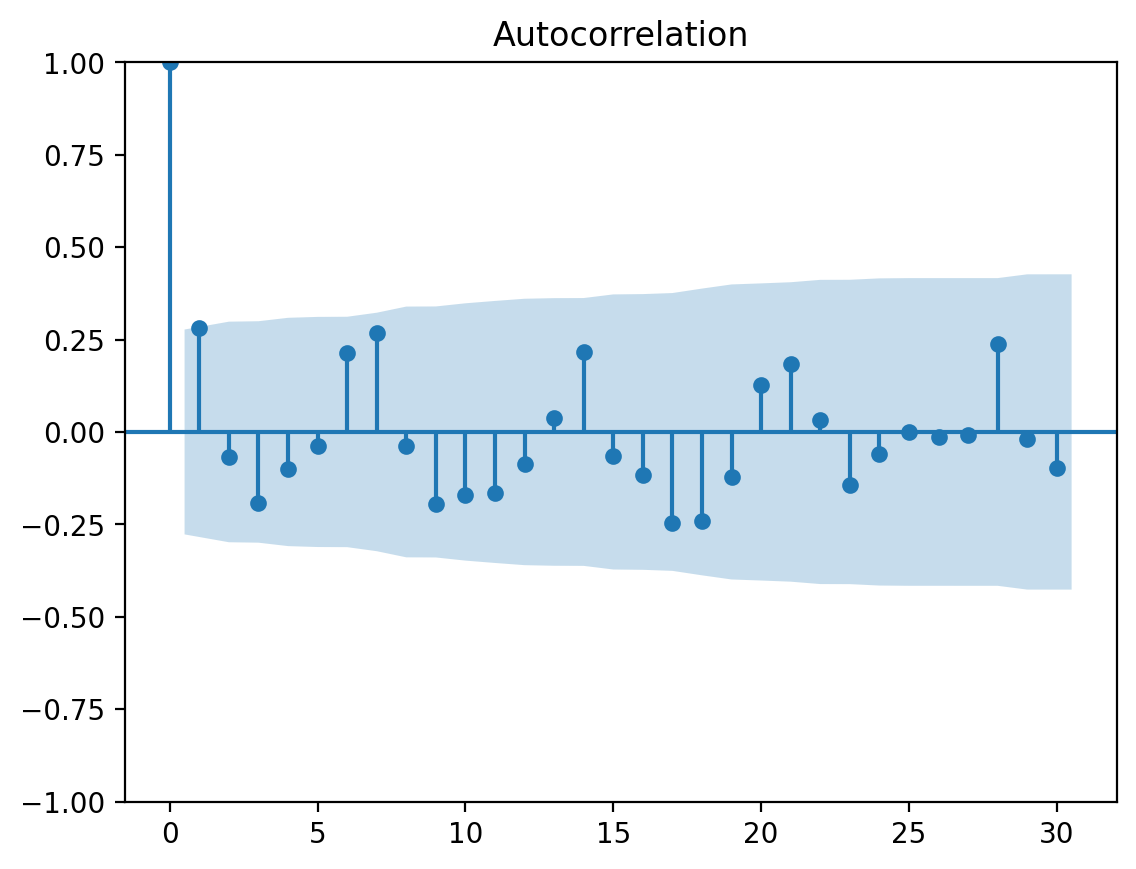

In [118]:
plt.figure(figsize=(14, 6))
plot_acf(resid, lags=30)
plt.show()

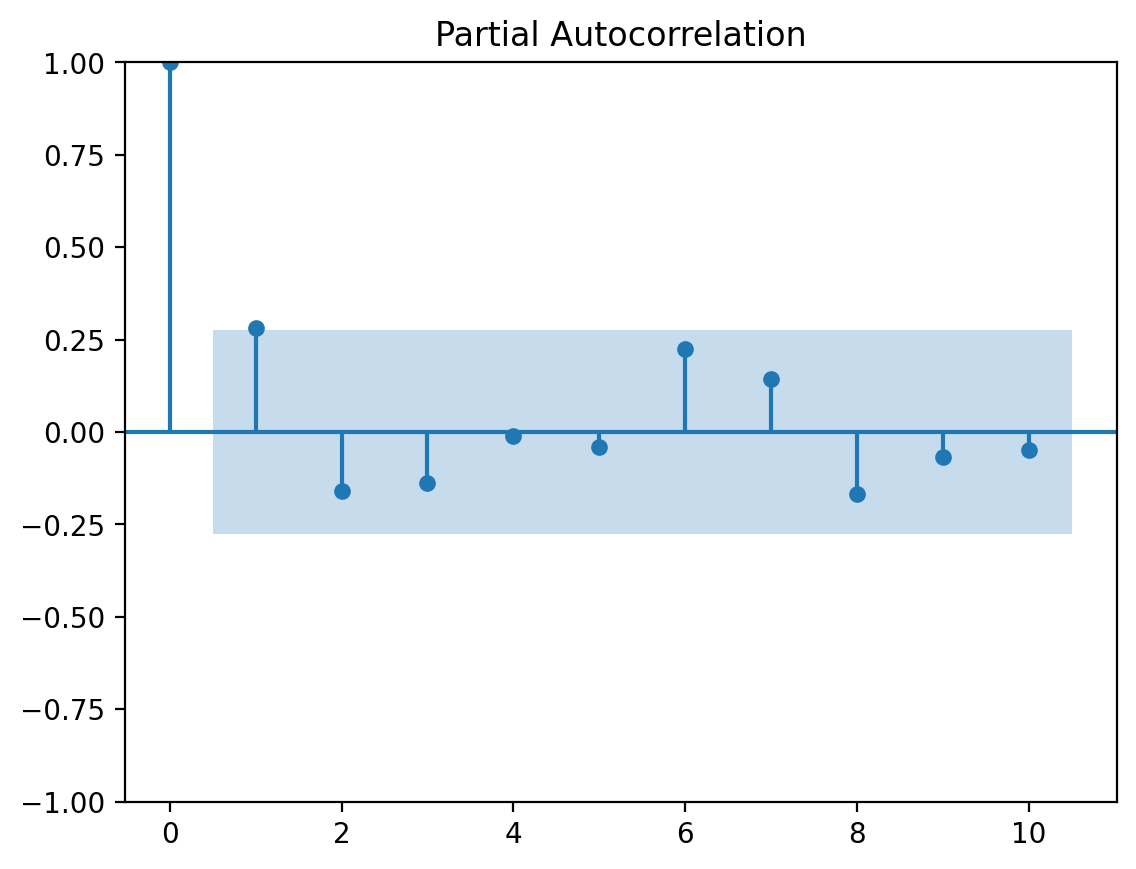

In [121]:
plot_pacf(resid, lags=10)
plt.show()

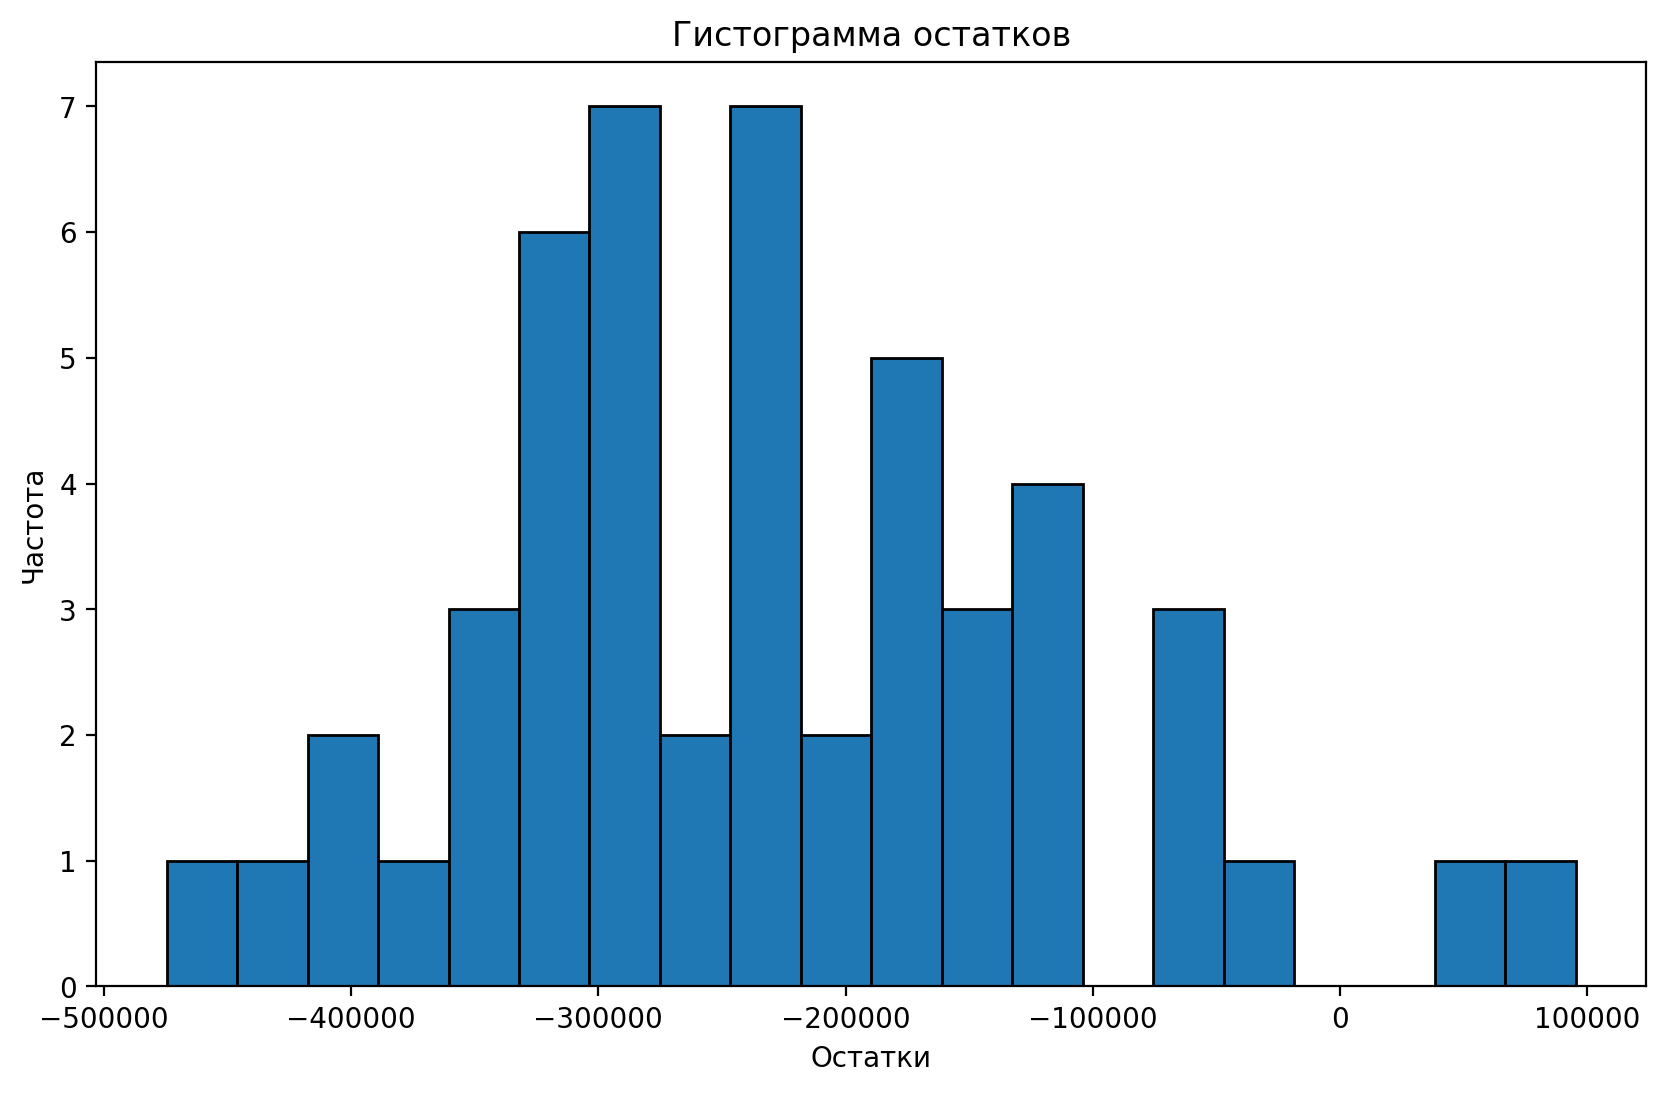

In [123]:
plot_histogram_residuals(resid, 'Гистограмма остатков')

In [125]:
print(f'Среднее остатков: {np.mean(resid)}')

Среднее остатков: -228266.45591077954


По остаткам все не очень хорошо, среднее далеко не ноль, есть кое-где частичная автокорреляция, распределение близко к нормальному, но все-таки не совсем похоже.

#### Интервальная оценка

Постройте интервальные оценки с надёжностью 95% Сколько раз на тестовой выборки наблюдаемые занчения выходили за пределы интевала? Какова реальная надёжность интервальной оценки на тестовой выборке? Проведите анализ все промахов: средняя величина промаха, частота промохов вниз и вверх и т.п. Какие меры можно использовать для оценки качества интервальной оценки? Вычислите эти меры.

In [126]:
# ваш код
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing

#### Сравнение моделей

Возьмите бенчмарк в виде сезонной наивной модели. Постройте прогноз такой модели на тест и подсчитайте MAE.
С помощью кросс-валидации выберите наилучшую по ETS-модель на основе любой другой метрике.

Сравните результаты.

In [ ]:
# ваш код

#### За лучшую работу начисляется 1 бонусный балл

## Выбор датасета для более поздних домашних заданий

Подберите набор данных из временных рядов. Этот набор данных вам понадобится начиная с ДЗ_3.

Датасет должен удовлетворять следующим условиям.
+ Минимальное число наблюдений для одного временного ряда - 200.
+ Минимальное число временных рядов в наборе - 20. Частота - любая.
+ Предметная область - любая, но финансовые временные ряды лучше на брать.
+ В данных должны присутствовать несколько переменных, одна из которых является целевой, а другие дополнительными признаками.
+ Должно быть понимание того, зачем нужно делать прогнозы целевой переменной.
+ Лучше брать набор однородных временных рядов. Спрос на разные товары, уровень загрязненность воздуха в разных точках, производство электроэнергии от разных ветрогенераторов и т.п. Данные, аналогичные данным конкурса M4 лучше не брать, но пряммого запрета нет.
+ Данные с сайта Kaggle можно брать, если они не участвовали в соревнованиях с денежным призом.
+ Данные с хакатонов брать можно.
  